In [2]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
from string import punctuation
import re
from collections import Counter
import matplotlib.pyplot as plt
print(os.listdir('data'))
print(punctuation)

['mindata.txt', 'labels.txt', 'reviews.txt']
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


## 将数据转为数字的格式

In [3]:
with open('data/labels.txt','r') as f:
    labels = f.readlines()
labels = "".join(labels).split('\n')
labels = torch.Tensor([1 if label=='positive' else 0 for label in labels]).long()
labels[:10]

tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [4]:
with open('data/reviews.txt') as f:
    reviews = "".join(f.readlines()).split('\n')
    reviews = [review.strip(" ") for review in reviews]

reviews[:2]

['bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t',
 'story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is t

In [5]:
def preprocessing(text):
    pattern = r"[!\"#$%&'()*+,-./:;<=>?[\]@^_`{|}\\\\~]"
    text = [re.sub(pattern,"",doc) for doc in text]
    allwords = " ".join(text).split()
    return text,allwords

reviews,allwords = preprocessing(reviews)

In [6]:
print(len(reviews),len(labels))

25001 25001


In [7]:
words = Counter(allwords)
len(words)

74072

In [8]:
words = [word for word,_ in words.most_common(30000)]
print(words[:10])

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in', 'i']


In [10]:
word_to_index = {word:index+1 for index,word in enumerate(words)}
index_to_word = {index+1:word for index,word in enumerate(words)}
word_to_index['<UNK>'] = 0
index_to_word[0] = '<UNK>'

In [11]:
def sentence_to_index(sentences):
    sentence_index = []
    for sentence in sentences:
        sentence_index.append([word_to_index.get(word,0) for word in sentence.split()])
    return sentence_index

reviews_index = sentence_to_index(reviews)
print(len(reviews_index))

25001


## 对齐句子长度 应该在embedding之后再对齐

In [12]:
reviews_len = [len(review) for review in reviews_index]
percentiles = np.array([0, 25, 50, 75,100])
ptiles_vers = np.percentile(reviews_len, percentiles)
print(ptiles_vers)

[   0.  130.  179.  293. 2514.]


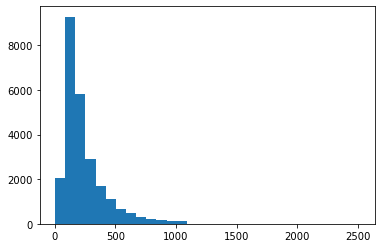

In [13]:
plt.hist(reviews_len,bins=30)
plt.show()

In [14]:
def pad_text(encoded_reviews, seq_length):
    
    reviews = []
    
    for review in encoded_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(review))+review)
        
    return torch.Tensor(reviews).long()
seq_length = 300
padded_reviews = pad_text(reviews_index,seq_length)
print(len(padded_reviews[1]))
print(padded_reviews[0])

300
tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

## 划分数据集

In [15]:
train_ratio = 0.7
valid_ratio = 0.1
total = padded_reviews.shape[0]
train_cutoff = int(total * train_ratio)
valid_cutoff = int(total * (train_ratio+valid_ratio))

train_x, train_y = padded_reviews[:train_cutoff], labels[:train_cutoff]
valid_x, valid_y = padded_reviews[train_cutoff:valid_cutoff], labels[train_cutoff:valid_cutoff]
test_x, test_y = padded_reviews[valid_cutoff:], labels[valid_cutoff:]

In [16]:
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

torch.Size([17500, 300])
torch.Size([2500, 300])
torch.Size([5001, 300])


In [17]:
train_data = TensorDataset(train_x, train_y)
valid_data = TensorDataset(valid_x, valid_y)
test_data = TensorDataset(test_x, test_y)

batch_size = 64
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [18]:
for index,(train_x,train_y) in enumerate(train_loader):
    if index>2:
        break
    print(train_x.shape,train_y.shape)

torch.Size([64, 300]) torch.Size([64])
torch.Size([64, 300]) torch.Size([64])
torch.Size([64, 300]) torch.Size([64])


## 搭建模型


In [19]:
class RNN(nn.Module):
    def __init__(self,vocab_size,emb_size,hidden_size,n_layers,out_size):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size,emb_size,padding_idx=0)
        self.rnn = nn.RNN(emb_size,hidden_size,num_layers=n_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,out_size)
    
    def forward(self,x):
        emb = self.emb(x) #batch_size*sequence_size*embed_size
        rnn_out,h = self.rnn(emb) #batch_size*sequence_size*hidden_size
        h = h.squeeze()
        output = torch.sigmoid(self.fc(h))
    
        return output

In [28]:
VOC_SIZE = 300001
EMB_SIZE = 128
HIDDEN_SIZE = 256
N_LAYERS = 1
DROP_P = 0.5
OUTPUT_SIZE = 1
LEARNING_RATE = 0.01
EPOCHS = 100
CLIP = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
model = RNN(VOC_SIZE,EMB_SIZE,HIDDEN_SIZE,N_LAYERS,OUTPUT_SIZE)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [30]:
model

RNN(
  (emb): Embedding(300001, 128, padding_idx=0)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [31]:
for epoch in range(EPOCHS):
    #if epoch==2:
    #   break
    for index,(train_x,train_y) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        output = model(train_x)
        optimizer.zero_grad()
        try:
            loss = criterion(output.squeeze(),train_y.float())
        except:
            print(output.shape)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        
        optimizer.step()
        if index%10==0:
            model.eval()
            v_losses = []
            for val_x,val_y in valid_loader:
                val_x = val_x.to(device)
                val_y = val_y.to(device)
                output = model(val_x)
                v_loss = criterion(output.squeeze(),val_y.float()) 
                v_losses.append(v_loss.item())
                
            print("epoch {}/{}, step {}, Train Loss:{:.4f}, Val Loss:{:.4f}"\
                  .format(epoch+1,EPOCHS,index,loss.item(),np.mean(v_losses)))
            model.train()
        

epoch 1/100, step 0, Train Loss:0.7186, Val Loss:0.8619


KeyboardInterrupt: 